#### Import and pre-process the data, train the VAE

**Import libraries used and mount a google drive**

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as imread
import numpy as np
import random
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
import pandas as pd
import scipy.stats as scp
from sklearn.metrics import roc_curve, auc

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Unzip the zip files with the data from the google drive**

In [2]:
start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/cae_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/novel_images.zip'

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

UNZIPPING TIME = 565.4656925201416



**Create lists with all path files to the images**

novel_path = list with all path files to the novel images

typical_path = list with all the path files to the typical images

In [0]:
novel_path = []
for path in os.listdir('/content/novel_images'):
    if path != '.DS_Store':
      full_path = os.path.join('/content/novel_images', path)
      novel_path.append(full_path)

typical_path = []
for path in os.listdir('/content/cae_train'):
    if path != '.DS_Store':
      full_path = os.path.join('/content/cae_train', path)
      typical_path.append(full_path)

#novel_path.sort()
#typical_path.sort()

**Convert the images' pixel values into float32**

All the values are savedd in float64, converting to float32 saves a lot of memory

The values are integers from 0 to 255, so converting to float32 doesn't looses any information

In [4]:
start_time = time.time()

for i in range (len(typical_path)):
  path = typical_path[i]
  image = np.load(path).astype('float32')
  np.save(path, image)

for i in range (len(novel_path)):
  path = novel_path[i]
  image = np.load(path).astype('float32')
  np.save(path, image)

print('CONVERTING TIME = {}\n'.format(time.time()-start_time))

CONVERTING TIME = 719.9531865119934



**Function to load images**

Takes an image path and returns its image array

In [0]:
def load_images(image_paths):
  images = []
  if np.shape(image_paths) == ():
    images.append(np.load(image_paths))
  else:
    for path in image_paths:
      img = np.load(path)
      images.append(img)
  return np.array(images)

**Function to plot an image**

Takes an image array and plots its 6 channels

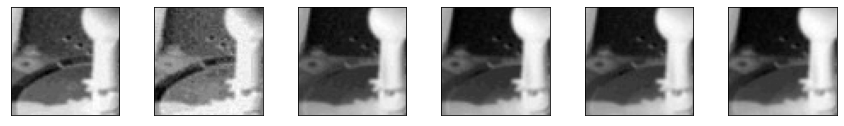

In [6]:
def plot_image(image):
    plot = plt.figure(figsize=[15,2])
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(image[0,:,:,i], cmap=plt.cm.binary)
    plt.show()

plot_image(load_images(typical_path[0]))

**Class of the Variational Autoencoder Models (two different models given, choose one)**

encode = takes an image and returns the mean and the log(variance) of its latent vector 

reparameterize = takes the mean and log(variance) of a latent vector and samples a vector from them

decode = takes a latent vector and returns the logits of the output (these will have to be passed through a sigmoid function to obtain the reconstruction of x)

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Input((64, 64, 6)),                          
                          tf.keras.layers.Conv2D(12, (7,7), strides = (1,1), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(8, (5,5), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(6, (3,3), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ], name='Encoder')

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(768, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(16, 16, 3)),
                          tf.keras.layers.Conv2DTranspose(8, (3,3), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2DTranspose(12, (5,5), strides = (2,2), padding = 'SAME'),
                          tf.keras.layers.Conv2DTranspose(6, (7,7), strides = (1,1), padding = 'SAME'),
                          ], name='Decoder')

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

#model = CVAE(768)
#model.encoder_nn.summary()
#model.decoder_nn.summary()

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Input((64, 64, 6)),                          
                          tf.keras.layers.Conv2D(32, (7,7), strides = (1,1), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Conv2D(128, (5,5), strides = (1,1), padding = 'SAME'),
                          tf.keras.layers.MaxPool2D((2,2), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Conv2D(64, (3,3), strides = (1,1), padding = 'SAME'),
                          tf.keras.layers.MaxPool2D((2,2), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Conv2D(6, (3,3), strides = (1,1), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2), 
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dense(z_size*2)
                          ], name='Encoder')

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(16*16*6, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Dense(16*16*6, activation='relu'),
                          tf.keras.layers.Reshape(target_shape=(16, 16, 6)),
                          tf.keras.layers.Conv2DTranspose(64, (3,3), strides = (1,1), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Conv2DTranspose(128, (5,5), strides = (2,2), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Conv2DTranspose(64, (7,7), strides = (2,2), padding = 'SAME'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.LeakyReLU(),
                          tf.keras.layers.Dropout(0.25),
                          tf.keras.layers.Conv2DTranspose(6, (7,7), strides = (1,1), padding = 'SAME'),
                          ], name='Decoder')

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

#model = CVAE(768)
#model.encoder_nn.summary()
#model.decoder_nn.summary()

**Function to compute the ELBO loss**

Takes an image and returns the ELBO loss. The term variance is a hyperparameter and can be changed

In [0]:
def calculate_ELBO(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  pixel_prob = tf.math.sigmoid(x_logit)

  variance = 0.2**2
  logpx_z = tf.reduce_sum(-.5 * (((x - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
  KL = -0.5*(tf.reduce_sum(tf.math.add(logvar,1), axis=1) - tf.reduce_sum(tf.exp(logvar), axis=1) - tf.reduce_sum(tf.exp(mean ** 2), axis=1))

  return -tf.reduce_mean(logpx_z - KL)

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a training a batch**

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


#def test_step(model, x, optimizer):
#    loss = calculate_ELBO(model, x)
#    test_loss(loss)
#def train_only_dataset(model, train_dataset, epochs):  
#  for epoch in range(epochs):
#    for train_x in train_dataset: 
#      train_step(model, train_x, optimizer)
#    loss = -train_loss.result()  
#  train_loss.reset_states()
#  return loss

**Split data into train ans test data**

Select the number of test images to be selected from both the typical and novel datasets (e.g. 100 and 32)

Select these images randomly or equally spaced throughout the dataset (to obtain the same datasets each time)

In [0]:
typical_test_n = 100
novel_test_n = 32

#typical_test_idx = random.sample(range(0, 98800), typical_test_n) #random
typical_test_idx = list((np.linspace(0,98800-1, typical_test_n)).astype('int')) #equally spaced
typical_train_idx = list(range(98800))
for i in typical_test_idx:
  typical_train_idx.remove(i)

typical_test_path = []
typical_train_path = []
for i in typical_test_idx:
  typical_test_path.append(typical_path[i])
for i in typical_train_idx:
  typical_train_path.append(typical_path[i])

#novel_test_idx = random.sample(range(0, 332), novel_test_n) #random
novel_test_idx = list(np.linspace(0,331,novel_test_n).astype('int')) #equally spaced
novel_train_idx = list(range(332))
for i in novel_test_idx:
  novel_train_idx.remove(i)

novel_test_path = []
novel_train_path = []
for i in novel_test_idx:
  novel_test_path.append(novel_path[i])
for i in novel_train_idx:
  novel_train_path.append(novel_path[i])

**Check amount of images in each dataset**

In [14]:
print(np.shape(typical_train_path))
print(np.shape(typical_test_path))
print(np.shape(novel_train_path))
print(np.shape(novel_test_path))

(98700,)
(100,)
(300,)
(32,)


**Define some constant terms**


In [0]:
N_typical_images_train = len(typical_train_path)
N_typical_images_test = len(typical_test_path)
N_novel_images_train = len(novel_train_path)
N_novel_images_test = len(novel_test_path)
img_height = load_images(typical_train_path[0]).shape[1]
img_width = load_images(typical_train_path[0]).shape[2]
img_channels = load_images(typical_train_path[0]).shape[3]
input_range = 255

**Function to create a dataset from images**

setup_dataset shuffles the images

setup_dataset_no_shuffle doesn't shuffle the images

In [0]:
def setup_dataset(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).batch(batch_size)
  return dataset

**Load model weights (if model was already trained)**

Load the weights of the model from the google drive if they were saved after training

In [0]:
z_size = 768
model = CVAE(z_size)
model.encoder_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Encoder/')
model.decoder_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Decoder/')
#model.encoder_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Encoder_Extra/')
#model.decoder_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Decoder_Extra/')

**Train the VAE**

Plots the loss curve every 10 batches

In [0]:
z_size = 768
model = CVAE(z_size)

batch_size = 200
batches_typical_images_train = (N_typical_images_train//batch_size)
epochs = 1

start_time = time.time()
losses = []
for j in range(epochs):
  typical_train_path = shuffle(typical_train_path, random_state=0)
  for i in range(batches_typical_images_train):
    images = load_images(typical_train_path[i*batch_size:(i+1)*batch_size])
    x = (images/255).astype('float32')
    loss = train_step(model, x, optimizer)
    losses = np.append(losses, loss.numpy())

    if i%10 == 0:
      clear_output()
      print(str(j) + '.' + str(i) + ' ---> ' + str(loss.numpy()))
      plt.plot(range(len(losses)), losses)
      plt.grid(which='both', axis='both')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

#save the model weights into google drive
#model.encoder_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Encoder/')
#model.decoder_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Decoder/')

**Function to reconstruct images**

Takes an image path and returns its reconstruction (and its ELBO loss)

Original Pictures:


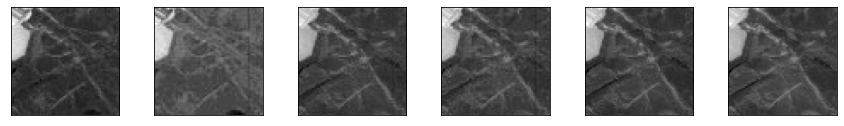

Reconstructed Pictures


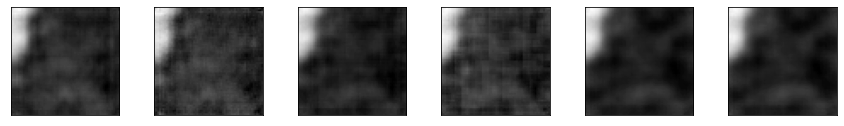

15938.907
Original Pictures:


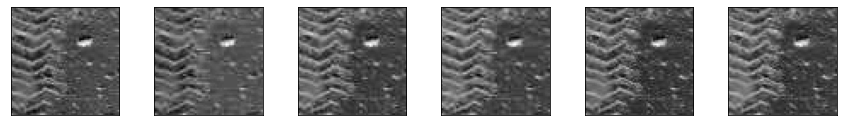

Reconstructed Pictures


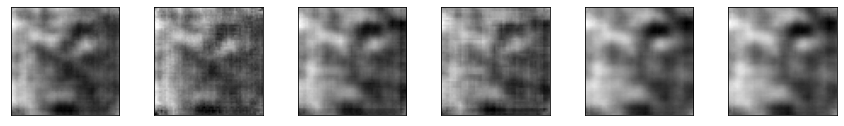

15683.859
Original Pictures:


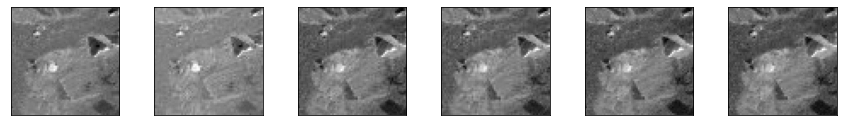

Reconstructed Pictures


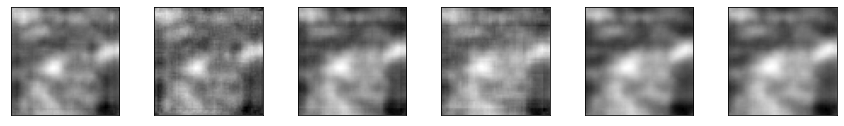

15990.367
Original Pictures:


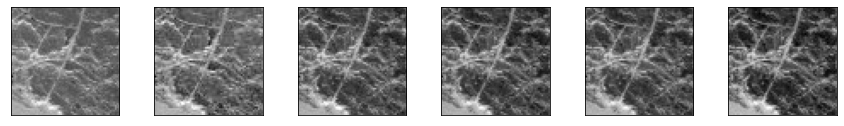

Reconstructed Pictures


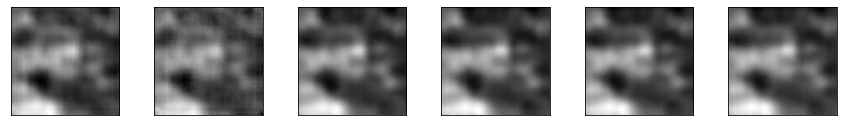

15388.183
Original Pictures:


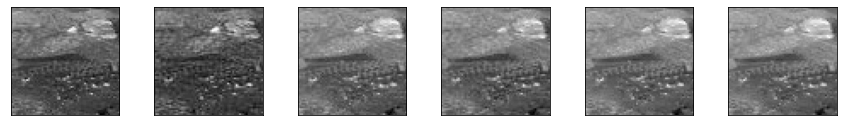

Reconstructed Pictures


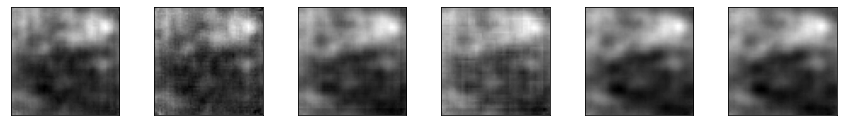

16017.09


In [20]:
def reconstruct_images(image_path):
    images = load_images(image_path)
    x = (images/255).astype('float32')

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    
    loss = -calculate_ELBO(model,x)
    loss = loss
    
    print('Original Pictures:')
    plot_image(x)
    print('Reconstructed Pictures')
    plot_image(pixel_prob)
    return loss

for i in range(5):
  loss = reconstruct_images(typical_train_path[i])
  print(loss.numpy())

**Function to visulaize the latent space**

Takes a list of image paths and the 2 dimension of the latent space to plot

2.3642776012420654


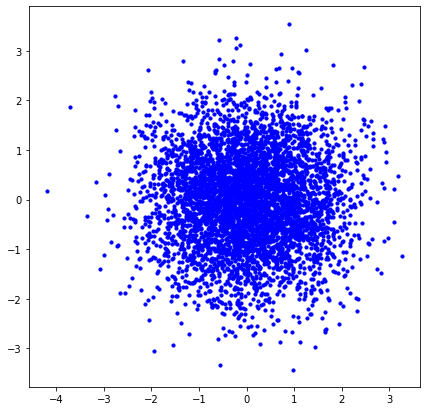

In [22]:
def visualize_latent_space(model, paths, dimensions):
  plot = plt.figure(figsize=[7,7])
  outlier = []
  latent_space = np.ndarray([0, model.z_size])
  for i in range(len(paths)//100):
      x = load_images(paths[i*100:(i+1)*100])
      x = (x/input_range).astype('float32')
      z_mean, z_logvar = model.encode(x)
      z = model.reparameterize(z_mean, z_logvar)
      latent_space = np.append(latent_space, z, axis=0)


  plt.scatter(latent_space[:, dimensions[0]], latent_space[:,dimensions[1]], color = 'blue', s=10)

  return latent_space, outlier

start_time = time.time()
latent_space, outlier = visualize_latent_space(model, typical_train_path[0:5000], [0,5])
print(time.time()-start_time)

**Compare latent space distribution to normal distribution**

Plots the distribution of various latent space dimensions with a histogram and superimposes a normal distribution for comparison

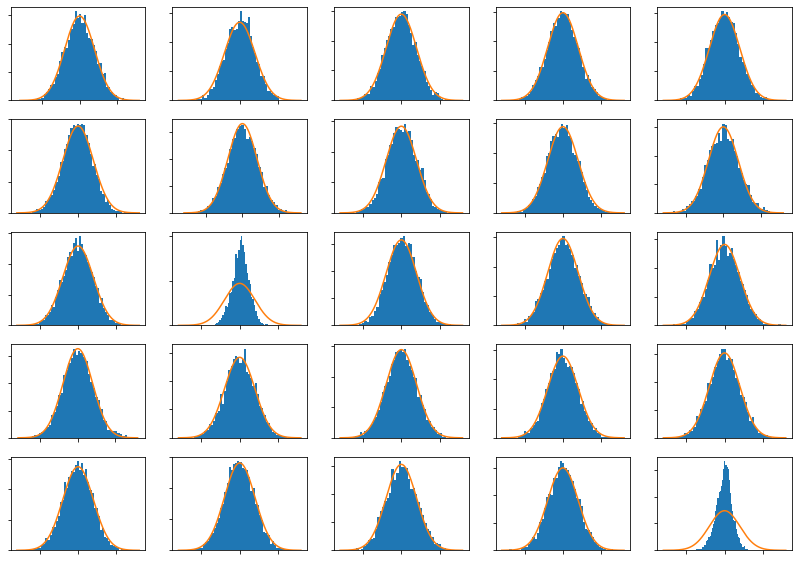

In [23]:
fig, axs = plt.subplots(5,5, figsize=(14, 10))
axs = axs.ravel()

a=0
for i in range(25):
    bins = 50
    scale = ((np.max(latent_space[:,i])-np.min(latent_space[:,i]))/bins)*len(latent_space[:,i])
    x_axis = np.arange(-4, 4, 0.001)
    axs[a].hist(latent_space[:,i], bins)
    y_vals = axs[a].get_yticks()
    axs[a].set_yticklabels([])
    axs[a].set_xticklabels([])
    axs[a].plot(x_axis, scp.norm.pdf(x_axis,0,1)*scale)
    a += 1
plt.show()

#### Write one-dimensional loss functions and test the unsupervised-model

**Write function for all 17 losses**

Each loss returns a scalar

Train-based losses takes as input the test image and the train data

Create a python dictionary with all the losses

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    pixel_squared = tf.math.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    variance = 0.2**2
    logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * 3.14)), axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z)
  return -losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return -losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return -losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    image_train = np.append(image_train, images, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  image_test = np.empty([0,64,64,6])
  for images in x_test:
    image_test = np.append(image_test, images, axis=0)
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  num = len(image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = -Loss_4(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_12(model, x):
  losses_per_image = -Loss_5(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_13(model, x):
  losses_per_image = -Loss_6(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)

    KL = -0.5*(tf.reduce_sum(tf.math.add(z_logvar,1), axis=1) - tf.reduce_sum(tf.exp(z_logvar), axis=1) - tf.reduce_sum(tf.exp(z_mean ** 2), axis=1))
    losses_per_image = np.append(losses_per_image, KL)
  return -losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

Loss_functions_dict = dict([(1,Loss_1),(2,Loss_2),(3,Loss_3),(4,Loss_4),(5,Loss_5),(6,Loss_6),(7,Loss_7),
                            (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                            (14,Loss_14),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

**Create function to plot an ROC curve and get values from it**

Takes the predictions of a class (y_score) and the labels of it (y_true): all values form 0 to 1

Returns: roc_auc, optimal_threshold, optimal_avgaccuracy_threshold (others not important)

roc_auc = area under the curve 

optimal_threshold = threshold corresponding to the point closest to the top-left edge

optimal_avgaccuracy_threshold = threshold corresponding to the highest weighted accuracy

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]

  optimal_accuracy_idx = np.argmax(tpr*300+((1-fpr)*98700))
  optimal_accuracy = (tpr[optimal_accuracy_idx]*300+((1-fpr[optimal_accuracy_idx])*98700))/99000
  optimal_accuracy_threshold = threshold[optimal_accuracy_idx]

  optimal_avgaccuracy_idx = np.argmax(tpr + 1 - fpr)
  optimal_avgaccuracy = (tpr[optimal_avgaccuracy_idx]+1-fpr[optimal_avgaccuracy_idx])/2
  optimal_avgaccuracy_threshold = threshold[optimal_avgaccuracy_idx]

  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.show()
  return roc_auc, optimal_threshold, optimal_accuracy, optimal_accuracy_threshold, optimal_avgaccuracy, optimal_avgaccuracy_threshold

**Create empty dictionaries to use later**

In [0]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

**Calculate results for all non train_based loss functions**

Add values to each of the dictionaries for each loss


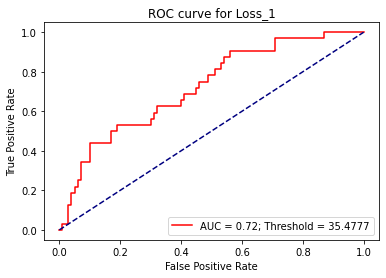

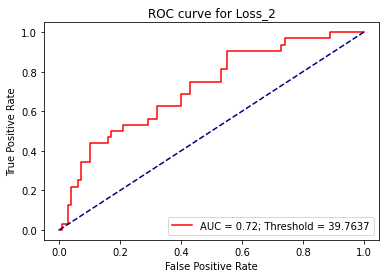

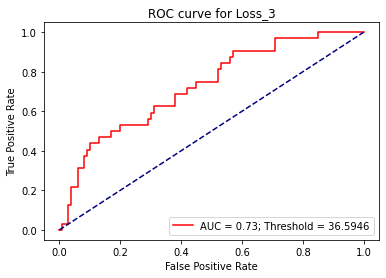

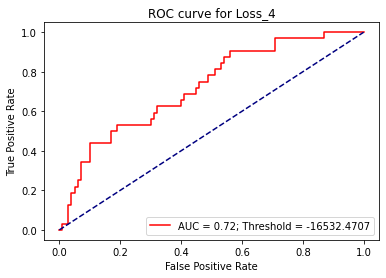

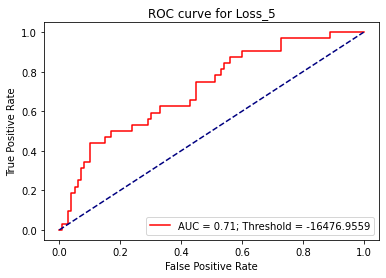

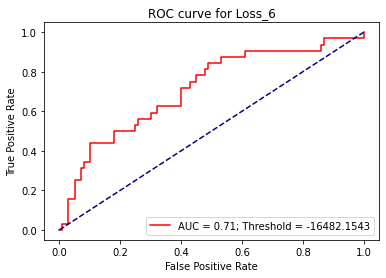

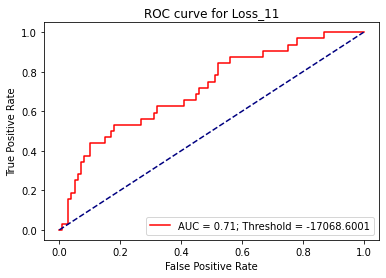

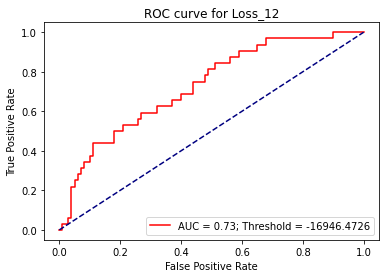

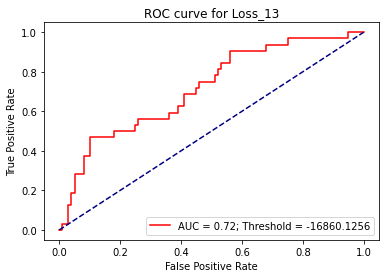

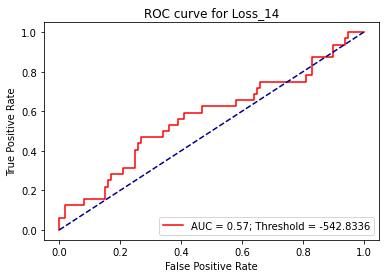

In [27]:
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    images = load_images(novel_test_path)
    dataset = setup_dataset(images.astype('float32'))
    losses = Loss_functions_dict[i](model, dataset)
    images = load_images(typical_test_path)
    dataset = setup_dataset(images.astype('float32'))
    losses = np.append(losses, Loss_functions_dict[i](model, dataset))
    y_true = np.zeros([len(losses),])
    y_true[0:N_novel_images_test] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

**Calculate results for a train_based loss function (will take much longer)**

Add values to each of the dictionaries for a train-based loss. Select "i" in the for loop as the loss number chosen (7,8,9,10,15,16 or 17).


In [0]:
for i in [7]:
    start_time= time.time()
    temp = np.empty([25,32])
    images = load_images(novel_test_path)
    dataset1 = setup_dataset_no_shuffle(images.astype('float32'))
    for j in range(25):
      print(j, end=' ')
      images = load_images(typical_train_path[4000*j:4000*j+4000])
      dataset2 = setup_dataset_no_shuffle(images.astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.min(temp, axis=0)

    temp = np.empty([25,100])
    images = load_images(typical_test_path)
    dataset1 = setup_dataset_no_shuffle(images.astype('float32'))
    for j in range(25):
      print(j, end=' ')
      images = load_images(typical_train_path[4000*j:4000*j+4000])
      dataset2 = setup_dataset_no_shuffle(images.astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.append(losses, np.min(temp, axis=0))

    y_true = np.zeros([len(losses),])
    y_true[0:32] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy
    print(time.time()-start_time)
    print(table_of_counts_dict[i])
    print(auc_dict[i])

**Print the results for all losses computed**

In [31]:
print('THRESHOLD METHOD RESULTS')
result_table = np.empty([len(auc_dict),7])
index = ['_']*len(auc_dict)
j = 0
for i in np.sort(list(auc_dict.keys())):
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.1f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

THRESHOLD METHOD RESULTS


,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,54.5,65.8,28,56,44,4,72.2
Loss_2,55.3,66.2,28,55,45,4,71.9
Loss_3,76.5,65.4,14,13,87,18,72.7
Loss_4,54.5,65.8,28,56,44,4,72.2
Loss_5,78,65.3,13,10,90,19,71.3
Loss_6,58.3,66.1,26,49,51,6,71.2
Loss_11,74.2,66,16,18,82,16,71.4
Loss_12,56.8,65.1,26,51,49,6,72.7
Loss_13,78.8,66.9,14,10,90,18,71.6
Loss_14,65.9,58.4,14,27,73,18,57.1


#### Write the high-dimensional loss functions and test the semi-supervised model

**Write the losses (only non train-based ones)**

Reconstruction based losses will return an error-map of shape 64x64x6

Latent space based losses will return a error-vector of shape z_size

In [0]:
def Loss_1_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, pixel_squared, axis=0)
  return losses_per_image

def Loss_2_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.mean(pixel_squared, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_3_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.min(pixel_squared, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_4_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    losses_per_image = np.append(losses_per_image, -logpx_z_pixels, axis=0)
  return losses_per_image

def Loss_5_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.mean(-logpx_z_pixels, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_6_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.min(-logpx_z_pixels, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_14_img(model, x):
  losses_per_image = np.empty((0, z_size))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = 0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    #KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_parameters, axis=0)
  return losses_per_image

Loss_functions_img_dict = dict([(1,Loss_1_img),(2,Loss_2_img),(3,Loss_3_img),(4,Loss_4_img),(5,Loss_5_img),(6,Loss_6_img),
                                (14,Loss_14_img)])

**Create directories where to save the error_map (or error_vector)**

In [0]:
os.mkdir('/content/error_map_typical_train/')
os.mkdir('/content/error_map_typical_test/')
os.mkdir('/content/error_map_novel_train/')
os.mkdir('/content/error_map_novel_test/')

##### Reconstruction losses

**Calculate error-maps for all dataset (typical/novel, train/test)**

Select a loss number to use, each error-map is calculated and saved into the directories made before

In [36]:
loss_num = 4
time1 = time.time()

print('Progress of error_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%10 == 0: print(str(i/100*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%30 == 0: print(str(i/300*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%3 == 0: print(str(i/30*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 100%
1331.2393682003021


**Create a list with file path names to each error-map saved**

In [0]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_train_path)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

**Function to create a dataset from images (with labels "y" too)**

setup_dataset shuffles the images

setup_dataset_no_shuffle doesn't shuffle the images

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

**Create classifier**

classify = takes an image and returns the output (logit) and the probability from 0 to 1 of the image being novel (prob)

In [40]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (64, 64, 6)) ,                        
                             tf.keras.layers.Conv2D(32, (5,5), padding='SAME', activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
                             tf.keras.layers.Conv2D(64, (5,5), padding='SAME', activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(rate=0.4),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4832      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

train_only_dataset = trains the the whole train-dataset for a certain number of epochs, reuturns the loss

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      
      train_step(model, train_x, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

**Define loss function of Classifier 1**

weighted cross entropy with weight of 10 (1000/100) to deal with class imbalance (reduced significantly by ROS)

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/83
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

**Train the classifier**

In [0]:
classifier = classifier_model()

9.97---> 1.769566


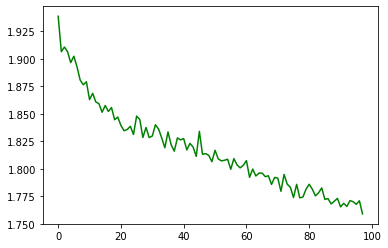

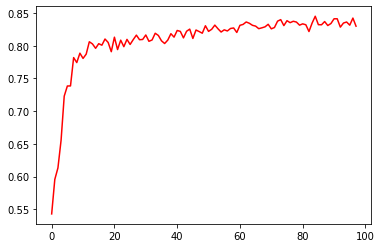

TRAINING TIME = 3726.101014137268



In [0]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 2

for j in range(epochs):

  typical = shuffle(errormap_typical_train_path)

  for i in range(98):
    novel = shuffle(errormap_novel_train_path)
    train_data = np.append(novel[0:83], typical[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset = setup_dataset(load_images(train_data), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(load_images(test_data))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

  #classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier/')

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

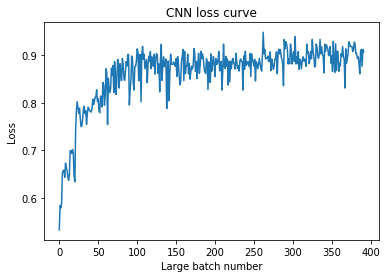

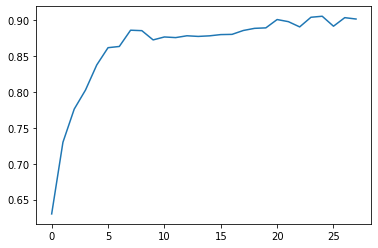

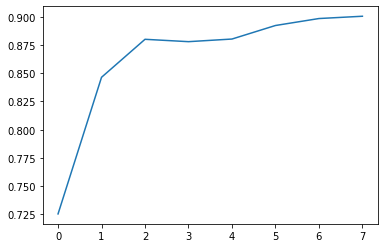

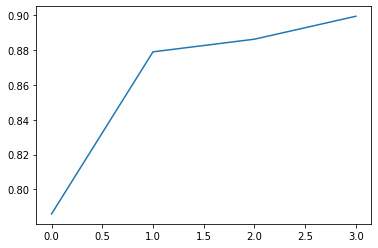

In [0]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
plt.savefig('/content/ROC_losses_graph/loss_curve_12')
plt.show()

a = np.reshape(l, [-1,14])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,49])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,98])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

**Predict the classes of the test data**

In [0]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:N_novel_images_test] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = load_images(test_data)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])
prob = np.array(prob[:,0])

#print(logits)
print(prob)

[0.8140702  0.75283265 0.8936474  0.92449194 0.934599   0.795879
 0.79317415 0.8653815  0.8165076  0.79258883 0.8341937  0.7626992
 0.8389724  0.80254954 0.9670514  0.8429499  0.8274367  0.7733558
 0.9708055  0.9356895  0.78398806 0.90848696 0.82146376 0.80109453
 0.98276377 0.8616568  0.8305015  0.8197881  0.88505447 0.8301075
 0.79429954 0.8146661  0.79847854 0.81085163 0.82431054 0.9784172
 0.8056335  0.8663822  0.8035543  0.78132385 0.94081664 0.845935
 0.8412018  0.8406092  0.79727644 0.8371972  0.7927721  0.8088971
 0.7934149  0.7863473  0.8242579  0.79179597 0.75611395 0.78495395
 0.85356456 0.7436166  0.9841764  0.8923913  0.79727113 0.8346609
 0.8205261  0.8402783  0.82020766 0.8736993  0.89373726 0.83912027
 0.9174776  0.8315681  0.81547344 0.8422808  0.9741417  0.9323754
 0.7747676  0.9697129  0.76346874 0.8088636  0.7922641  0.97846985
 0.7694142  0.8996118  0.813776   0.6708269  0.8008297  0.76961106
 0.82660156 0.93296134 0.7656031  0.78428215 0.82042456 0.8217118
 0.8063

**Calculate results from ROC**


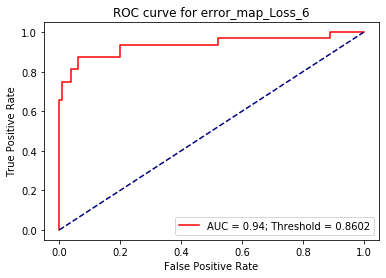

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,91.7,89.2,27,6,94,5,93.6


In [0]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(prob > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

##### Latent space losses

###### Calculate Loss 14 (non train-based)

**Save all the error-vectors in the directories**

In [0]:
def setup_dataset(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).batch(batch_size)
  return dataset

In [48]:
loss_num = 14
time1 = time.time()

print('Progress of error_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%10 == 0: print(str(i/1000*10) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%30 == 0: print(str(i/300*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%3 == 0: print(str(i/30*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 0.1%, 0.2%, 0.3%, 0.4%, 0.5%, 0.6%, 0.7000000000000001%, 0.8%, 0.8999999999999999%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 100%
930.660737991333


**Create a list of path file names for each error-vector**

In [0]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_train_path)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

###### Calculate Losses 15, 16 or 17 (train-based)

**Split the training typical dataset into 2**

One will be used to calculate the losses for the other

In [0]:
os.mkdir('/content/error_map_typical_train_1/')

In [0]:
typical_1 = shuffle(typical_train_path[0:50000])
typical_2 = shuffle(typical_train_path[50000:98700])

**Save all the values of z_mean and z_logvariance**

These will be calculated and saved for the typical/novel and train/test datasets; they will be used later to calculate the losses

In [52]:
time1 = time.time()

print('Progress of error_map_typical_train_1')
for i in range(len(typical_1)):
    if i%(len(typical_1)/100*5) == 0: print(str(int(i/len(typical_1)*100)) + '%,', end = ' ')
    images = load_images(typical_1[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_typical_train_1/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_typical_train')
for i in range(len(typical_2)):
    if i%(len(typical_2)/100*5) == 0: print(str(int(i/len(typical_2)*100)) + '%,', end = ' ')
    images = load_images(typical_2[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_typical_train/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%10 == 0: print(str(i/100*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_typical_test/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%30 == 0: print(str(i/300*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_novel_train/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%3 == 0: print(str(i/30*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_novel_test/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train_1
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 100%
588.4366207122803


**Create a list of path file names for each error-vector**

In [53]:
errormap_typical_train_1_path = []
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_1)):
  errormap_typical_train_1_path.append('/content/error_map_typical_train_1/'+str(i)+'.npy')

for i in range(len(typical_2)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train_1 = ' + str(len(errormap_typical_train_1_path)))
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train_1 = 50000
losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


**Calculate loss_15 (and save on google drive folder)**

Saved in google drive rather than google colab because this makes sure that they only have to be calculated once, and not every time. See later when they are used

In [0]:
loss_num = 15

time1 = time.time()

b = np.squeeze(load_images(errormap_typical_train_1_path))

print('Progress of error_map_typical_train')
a = np.squeeze(load_images(errormap_typical_train_path))
for k in range(len(a)):
    if k%2500 == 0: print(str(int(k/len(a)*100)) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/typical_train/'+str(k), temp[index])
print('100%')


print('Progress of error_map_typical_test')
a = np.squeeze(load_images(errormap_typical_test_path))
for k in range(len(a)):
    if k%10 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/typical_test/'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_train')
a = np.squeeze(load_images(errormap_novel_train_path))
for k in range(len(a)):
    if k%30 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/novel_train/'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_test')
a = np.squeeze(load_images(errormap_novel_test_path))
for k in range(len(a)):
    if k%4 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/novel_test/'+str(k), temp[index])
print('100%')

print(time.time()-time1)

**Calculate loss_16 (and save on google drive folder)**

Saved in google drive rather than google colab because this makes sure that they only have to be calculated once, and not every time. See later when they are used

In [0]:
loss_num = 16

time1 = time.time()

b = np.squeeze(load_images(errormap_typical_train_1_path))

print('Progress of error_map_typical_train')
a = np.squeeze(load_images(errormap_typical_train_path))
for k in range(len(a)):
    if k%2500 == 0: print(str(int(k/len(a)*100)) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/typical_train/'+str(k), temp[index])
print('100%')


print('Progress of error_map_typical_test')
a = np.squeeze(load_images(errormap_typical_test_path))
for k in range(len(a)):
    if k%10 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/typical_test/'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_train')
a = np.squeeze(load_images(errormap_novel_train_path))
for k in range(len(a)):
    if k%30 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/novel_train//'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_test')
a = np.squeeze(load_images(errormap_novel_test_path))
for k in range(len(a)):
    if k%4 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/novel_test/'+str(k), temp[index])
print('100%')

print(time.time()-time1)

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_test
0.0%, 12.5%, 25.0%, 37.5%, 50.0%, 62.5%, 75.0%, 87.5%, 100%
426.32987809181213


**Calculate loss_17 (and save on google drive folder)**

Saved in google drive rather than google colab because this makes sure that they only have to be calculated once, and not every time. See later when they are used

In [0]:
loss_num = 17

time1 = time.time()

b = np.squeeze(load_images(errormap_typical_train_1_path))

print('Progress of error_map_typical_train')
a = np.squeeze(load_images(errormap_typical_train_path))
for k in range(36569, len(a)):
    if k%2500 == 0: print(str(int(k/len(a)*100)) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/typical_train/'+str(k), temp)
print('100%')


print('Progress of error_map_typical_test')
a = np.squeeze(load_images(errormap_typical_test_path))
for k in range(len(a)):
    if k%10 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/typical_test/'+str(k), temp)
print('100%')


print('Progress of error_map_novel_train')
a = np.squeeze(load_images(errormap_novel_train_path))
for k in range(len(a)):
    if k%30 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/novel_train//'+str(k), temp)
print('100%')


print('Progress of error_map_novel_test')
a = np.squeeze(load_images(errormap_novel_test_path))
for k in range(len(a)):
    if k%4 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/novel_test/'+str(k), temp)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
77%, 82%, 87%, 92%, 97%, 100%
Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_test
0.0%, 12.5%, 25.0%, 37.5%, 50.0%, 62.5%, 75.0%, 87.5%, 100%
12553.724362373352


**Zip the losses saved on the google drive directory, and unzip the one needed here in google colab**

When they were computed they could've just been saved on google colab instead of the google drive, avoiding this redunding step. However saving them on the google drive made sure that I only had to compute them once and not every time.

In [0]:
!rm -rf error_map_typical_train_1
!rm -rf error_map_typical_train
!rm -rf error_map_typical_test
!rm -rf error_map_novel_train
!rm -rf error_map_novel_test

In [57]:
loss_num = 15

start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_test.zip'

!mv /content/typical_train /content/error_map_typical_train
!mv /content/typical_test /content/error_map_typical_test
!mv /content/novel_train /content/error_map_novel_train
!mv /content/novel_test /content/error_map_novel_test

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

UNZIPPING TIME = 69.02214312553406



In [0]:
loss_num = 16

start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_test.zip'

!mv /content/typical_train /content/error_map_typical_train
!mv /content/typical_test /content/error_map_typical_test
!mv /content/novel_train /content/error_map_novel_train
!mv /content/novel_test /content/error_map_novel_test

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

UNZIPPING TIME = 19.641529083251953



In [0]:
loss_num = 17

start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_test.zip'

!mv /content/typical_train /content/error_map_typical_train
!mv /content/typical_test /content/error_map_typical_test
!mv /content/novel_train /content/error_map_novel_train
!mv /content/novel_test /content/error_map_novel_test

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

###### Classify

**Check data**

Check amount of images per dataset

Plot image, reconstruction, and latent vector (for typical and novel)

CHECK LEN
losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32

TYPICAL IMAGE 1:
Original Pictures:


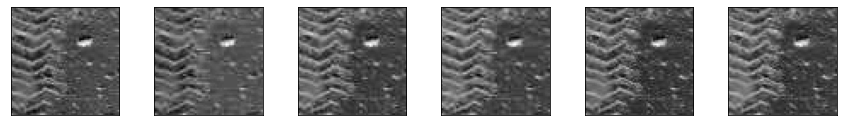

Reconstructed Pictures


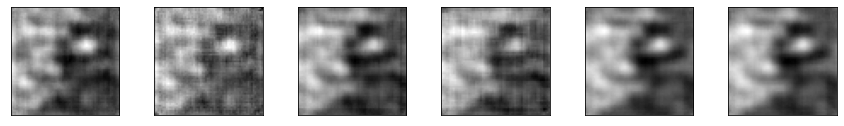

Error Map


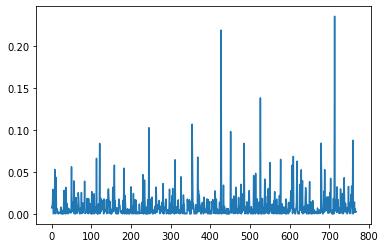


NOVEL IMAGE 0:
Original Pictures:


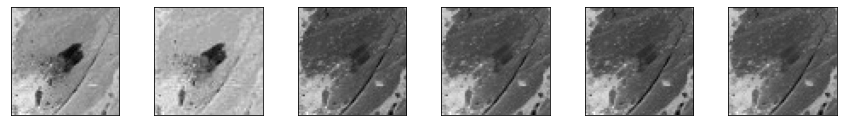

Reconstructed Pictures


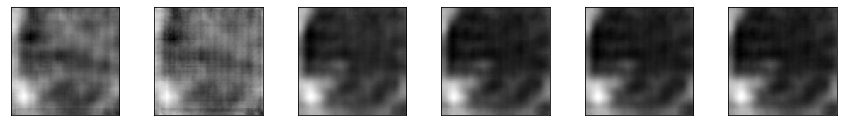

Error Map


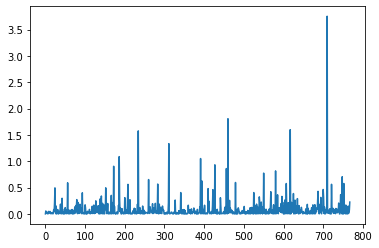

In [58]:
print('CHECK LEN')
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

i = 1
print('\nTYPICAL IMAGE ' + str(i) + ':')
reconstruct_images(typical_train_path[i])
print('Error Map')
a = np.squeeze(load_images(errormap_typical_train_path[i]))
plt.plot(range(len(a)), a)
plt.show()

i = 0
print('\nNOVEL IMAGE ' + str(i) + ':')
reconstruct_images(novel_train_path[i])
print('Error Map')
b = np.squeeze(load_images(errormap_novel_train_path[i]))
plt.plot(range(len(b)), b)
plt.show()

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

**Create classifier**

classify = takes an image and return the output (logit) or a probability between 0 and 1 of the image being novel (prob)

In [61]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (768,)),
                             #tf.keras.layers.Dense(1000, activation='relu'),
                             tf.keras.layers.Dense(1000, activation='relu'),
                             tf.keras.layers.Dense(500, activation='relu'),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1000)              769000    
_________________________________________________________________
dense_12 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 501       
Total params: 1,270,001
Trainable params: 1,270,001
Non-trainable params: 0
_________________________________________________________________


**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

train_only_dataset = trains the the whole train-dataset for a certain number of epochs, reuturns the loss

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      
      train_step(model, train_x, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

**Define loss function of Classifier 1**

weighted cross entropy with weight of 10 (1000/100) to deal with class imbalance (reduced significantly by ROS)

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/100
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

**Train the classifier**

change the i range to 48 or 97 if using a train-based loss or not

In [0]:
classifier = classifier_model()

3.45---> 1.7056991


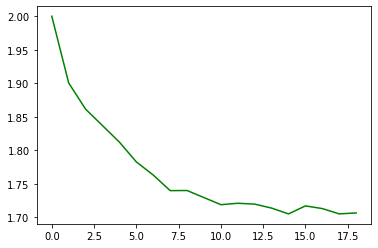

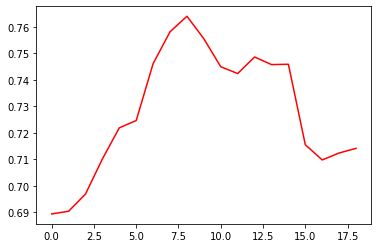

TRAINING TIME = 71.60003328323364



In [71]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 4

loss_max = 0
a = 0

for j in range(epochs):
  typical = shuffle(errormap_typical_train_path)

  for i in range(48):
    novel = shuffle(errormap_novel_train_path)
    train_data = np.append(novel[0:100], typical[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset = setup_dataset(load_images(train_data), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(load_images(test_data))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if l > loss_max:
        classifier.save_weights('/content/Classifier_Weights/')
        loss_max = l
        area = a

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))
classifier.load_weights('/content/Classifier_Weights/')

**Predict test images**

In [72]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:N_novel_images_test] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = load_images(test_data)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])
prob = np.array(prob[:,0])

#print(logits)
print(prob)

[0.7019025  0.6949553  0.786036   0.7043369  0.7654132  0.73709214
 0.7304452  0.7296325  0.7446314  0.7224664  0.7453542  0.71541727
 0.9151268  0.7087011  0.709294   0.69747543 0.7115701  0.7153736
 0.79978216 0.9543066  0.70218503 0.87410605 0.8002138  0.7069513
 0.9449667  0.81880045 0.7190175  0.74580187 0.8326233  0.8176837
 0.77235097 0.88258594 0.769456   0.70710266 0.762564   0.73574585
 0.711327   0.70396525 0.7070679  0.8543271  0.7791112  0.76778847
 0.7143524  0.9041611  0.6957447  0.7310272  0.7083484  0.8349956
 0.69650435 0.7016904  0.8325769  0.6974257  0.69713026 0.69569314
 0.70004785 0.7014723  0.77878594 0.8541511  0.7693202  0.7666208
 0.80716276 0.78814644 0.7018361  0.7342599  0.7009828  0.7276971
 0.7567482  0.8512423  0.69675785 0.7212141  0.73395467 0.7428749
 0.7075108  0.7679634  0.717169   0.77186686 0.69325477 0.7753809
 0.7019224  0.7968612  0.70090586 0.7611487  0.69926447 0.88884246
 0.80478776 0.8408211  0.6969857  0.70237464 0.6966847  0.7111041
 0.6

**Compute results**

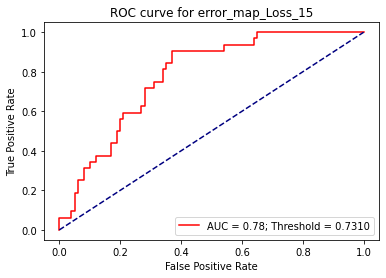

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,68.9,75.2,28,37,63,4,78


In [73]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(prob > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

##### Mixed losses

###### Latent space losses combinations

**Create list of file paths names**

In [74]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(48700):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(100):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(300):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(32):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


**Unzip all the latent space losses (saved before on google drive)**

For each loss unzipped, add them to obtain a vector with 4 channels (z_size x 4) rather than adding them in one long vector (z_size*4 x 1)

In [0]:
!rm -rf error_map_typical_train
!rm -rf error_map_typical_test
!rm -rf error_map_novel_train
!rm -rf error_map_novel_test

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_test.zip'

!mv /content/typical_train /content/error_map_typical_train
!mv /content/typical_test /content/error_map_typical_test
!mv /content/novel_train /content/error_map_novel_train
!mv /content/novel_test /content/error_map_novel_test

clear_output()

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_test.zip'

for i in range(len(errormap_typical_train_path)):
  a = load_images(errormap_typical_train_path[i])
  b = load_images('/content/typical_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_train_path[i], c)

for i in range(len(errormap_typical_test_path)):
  a = load_images(errormap_typical_test_path[i])
  b = load_images('/content/typical_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_test_path[i], c)

for i in range(len(errormap_novel_train_path)):
  a = load_images(errormap_novel_train_path[i])
  b = load_images('/content/novel_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_train_path[i], c)

for i in range(len(errormap_novel_test_path)):
  a = load_images(errormap_novel_test_path[i])
  b = load_images('/content/novel_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_test_path[i], c)

!rm -rf typical_train
!rm -rf typical_test
!rm -rf novel_train
!rm -rf novel_test

clear_output()

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_test.zip'

for i in range(len(errormap_typical_train_path)):
  a = np.load(errormap_typical_train_path[i])
  b = load_images('/content/typical_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_train_path[i], c)

for i in range(len(errormap_typical_test_path)):
  a = np.load(errormap_typical_test_path[i])
  b = load_images('/content/typical_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_test_path[i], c)

for i in range(len(errormap_novel_train_path)):
  a = np.load(errormap_novel_train_path[i])
  b = load_images('/content/novel_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_train_path[i], c)

for i in range(len(errormap_novel_test_path)):
  a = np.load(errormap_novel_test_path[i])
  b = load_images('/content/novel_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_test_path[i], c)

!rm -rf typical_train
!rm -rf typical_test
!rm -rf novel_train
!rm -rf novel_test

clear_output()

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/novel_test.zip'

for i in range(len(errormap_typical_train_path)):
  a = np.load(errormap_typical_train_path[i])
  b = load_images('/content/typical_train/'+str(i+50000)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_train_path[i], c)

for i in range(len(errormap_typical_test_path)):
  a = np.load(errormap_typical_test_path[i])
  b = load_images('/content/typical_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_test_path[i], c)

for i in range(len(errormap_novel_train_path)):
  a = np.load(errormap_novel_train_path[i])
  b = load_images('/content/novel_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_train_path[i], c)

for i in range(len(errormap_novel_test_path)):
  a = np.load(errormap_novel_test_path[i])
  b = load_images('/content/novel_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_test_path[i], c)

!rm -rf typical_train
!rm -rf typical_test
!rm -rf novel_train
!rm -rf novel_test

clear_output()

**Check data**

Check amount of data per set

Plot a channel of the error-vector (which has four channel), for a typical and novel image

CHECK LEN
losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32

Error Map Typical Image


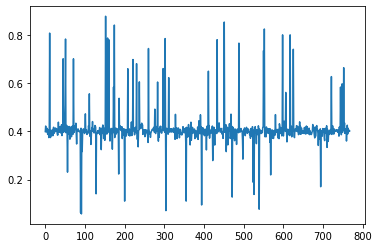

Error Map Novel Image


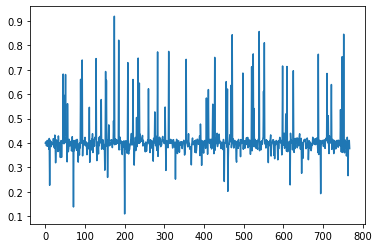

In [85]:
print('CHECK LEN')
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

i = 0
print('\nError Map Typical Image')
a = np.squeeze(load_images(errormap_typical_train_path[i]))
plt.plot(range(a.shape[1]), a[0,:])
plt.show()

i = 1
print('Error Map Novel Image')
b = np.squeeze(load_images(errormap_novel_train_path[i]))
plt.plot(range(b.shape[1]), b[0,:])
plt.show()

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

**Create classifier**

classify = takes an image and return the output (logit) or a probability between 0 and 1 of the image being novel (prob)

In [87]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (1, 768, 4)),
                             tf.keras.layers.Conv2D(50, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Conv2D(20, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Conv2D(8, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Conv2D(1, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Flatten(),                             
                             #tf.keras.layers.Dense(1000, activation='relu'),
                             tf.keras.layers.Dense(1000, activation='relu'),
                             tf.keras.layers.Dense(500, activation='relu'),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 768, 50)        250       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 768, 20)        1020      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 768, 8)         168       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 768, 1)         9         
_________________________________________________________________
flatten_4 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              769000    
_________________________________________________________________
dense_21 (Dense)             (None, 500)               5

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

train_only_dataset = trains the the whole train-dataset for a certain number of epochs, reuturns the loss

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      
      train_step(model, train_x, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

**Define loss function of Classifier 1**

weighted cross entropy with weight of 10 (1000/100) to deal with class imbalance (reduced significantly by ROS)

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/100
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

**Train the classifier**

In [0]:
classifier = classifier_model()

In [0]:
N_novel_images_test = 32
N_novel_images_train =300

9.47---> 1.5672569


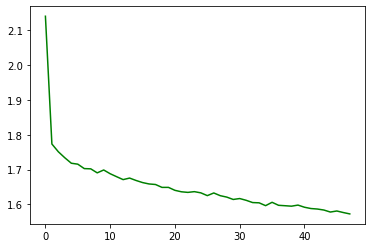

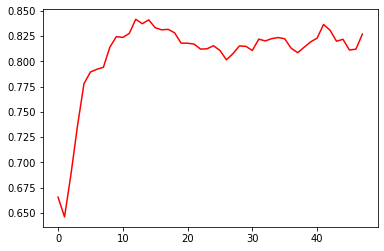

TRAINING TIME = 287.42120265960693



In [105]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 10

loss_max = 0
area = 0

for j in range(epochs):
  typical = shuffle(errormap_typical_train_path)

  for i in range(48):
    novel = shuffle(errormap_novel_train_path)
    train_data = np.append(novel[0:100], typical[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset = setup_dataset(np.expand_dims(np.swapaxes(load_images(train_data), 1, 2), 1), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(np.expand_dims(np.swapaxes(load_images(test_data), 1, 2), 1))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if l > loss_max:
        classifier.save_weights('/content/Classifier_Weights/')
        loss_max = l
        area = a

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))
classifier.load_weights('/content/Classifier_Weights/')

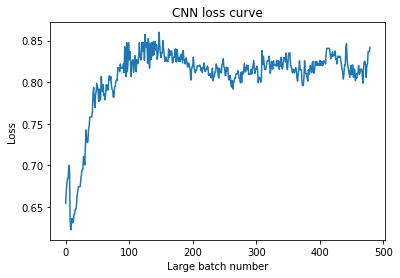

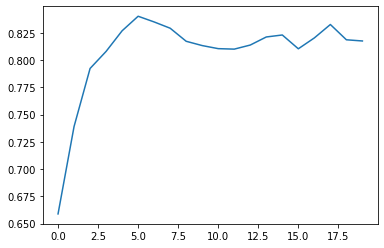

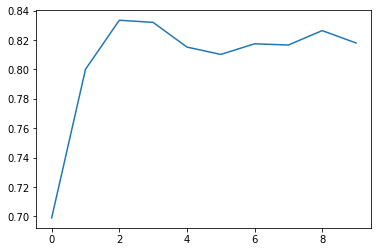

In [106]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
plt.show()


a = np.reshape(l, [-1,24])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,48])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

**Calculate test images novelty score**

In [107]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:N_novel_images_test] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = np.expand_dims(np.swapaxes(load_images(test_data), 1, 2), 1)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])
prob = np.array(prob[:,0])

#print(logits)
print(prob)

[0.6393336  0.7127399  0.7870033  0.78012264 0.77139616 0.7347332
 0.7227876  0.6202477  0.74352056 0.7296579  0.6854955  0.7206317
 0.762884   0.69001263 0.8315673  0.68379384 0.7273285  0.85986805
 0.91702336 0.8893341  0.7045542  0.83976084 0.7678957  0.7155125
 0.8031949  0.7992151  0.7507868  0.8170804  0.74666744 0.7999224
 0.72540444 0.799459   0.7927681  0.74297565 0.7764661  0.8967859
 0.76769215 0.8174391  0.68402606 0.75487804 0.9221465  0.89413184
 0.8382786  0.86531943 0.72066885 0.8611802  0.77065235 0.810484
 0.72060907 0.7676793  0.7662909  0.7050105  0.73721534 0.7170319
 0.82847977 0.72753346 0.9106811  0.77178854 0.7775211  0.8560774
 0.6403999  0.78377026 0.7249443  0.7765621  0.72684807 0.63032365
 0.7722929  0.8110848  0.6924496  0.7540392  0.84643066 0.8502213
 0.7776475  0.77428895 0.747613   0.78936136 0.74346274 0.82452136
 0.69203556 0.8534646  0.704211   0.8414016  0.7563746  0.9308189
 0.6640373  0.8973167  0.7792219  0.71946895 0.7336569  0.7453027
 0.7128

**Calculate results**

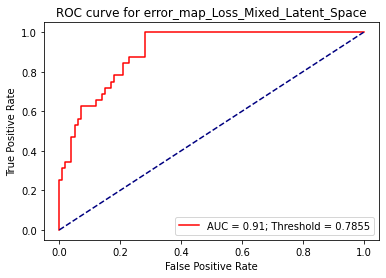

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,78,84.4,31,28,72,1,90.5


In [109]:
loss_num = 'Mixed_Latent_Space'

auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(prob > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

###### Reconstruction + Latent pace loss

In [0]:
os.mkdir('/content/error_map_typical_train/')
os.mkdir('/content/error_map_typical_test/')
os.mkdir('/content/error_map_novel_train/')
os.mkdir('/content/error_map_novel_test/')

In [0]:
def setup_dataset(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).batch(batch_size)
  return dataset

**Calculate and save loss 4 error-maps, then create list of file path names for them**

In [113]:
loss_num = 4
time1 = time.time()

print('Progress of error_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%10 == 0: print(str(i/100*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%30 == 0: print(str(i/300*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%3 == 0: print(str(i/30*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 100%
1410.0575194358826


In [114]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(98700):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(100):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(300):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(32):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train = 98700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


**Calculate and save loss 14 error-vectors, then create list of file path names for them**

In [0]:
os.mkdir('/content/latent_map_typical_train/')
os.mkdir('/content/latent_map_typical_test/')
os.mkdir('/content/latent_map_novel_train/')
os.mkdir('/content/latent_map_novel_test/')

In [116]:
loss_num = 14
time1 = time.time()

print('Progress of latent_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of latent_map_typical_test')
for i in range(len(typical_test_path)):
    if i%10 == 0: print(str(i/100*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of latent_map_novel_train')
for i in range(len(novel_train_path)):
    if i%30 == 0: print(str(i/300*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of latent_map_novel_test')
for i in range(len(novel_test_path)):
    if i%3 == 0: print(str(i/30*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of latent_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of latent_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of latent_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of latent_map_novel_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 100%
981.5870587825775


In [125]:
latent_typical_train_path = []
latent_typical_test_path = []
latent_novel_train_path = []
latent_novel_test_path = []

for i in range(98700):
  latent_typical_train_path.append('/content/latent_map_typical_train/'+str(i)+'.npy')

for i in range(100):
  latent_typical_test_path.append('/content/latent_map_typical_test/'+str(i)+'.npy')

for i in range(300):
  latent_novel_train_path.append('/content/latent_map_novel_train/'+str(i)+'.npy')

for i in range(32):
  latent_novel_test_path.append('/content/latent_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train = ' + str(len(latent_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(latent_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(latent_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(latent_novel_test_path)))

losses_typical_img_train = 98700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


**Create classifier model (classifier 4)**

The error-vector is appended to the error-map after the latter goes though some convolutional layers

In [0]:
input1 = tf.keras.layers.Input(shape = (64, 64, 6))
x1 = tf.keras.layers.Conv2D(32, (5,5), padding='SAME', activation='relu', name='x1')(input1)
x2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='x2')(x1)
x3 = tf.keras.layers.Conv2D(64, (5,5), padding='SAME', activation='relu', name='x3')(x2)
x4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='x4')(x3)
x5 = tf.keras.layers.Flatten(name='x5')(x4)

input2 = tf.keras.layers.Input(shape=(768,))

added = tf.keras.layers.concatenate([x5, input2])
added2 = tf.keras.layers.Dense(512, activation='relu', name='added2')(added)
out = tf.keras.layers.Dense(1, name='out')(added2)

classifier = tf.keras.models.Model(inputs=[input1, input2], outputs=out)

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00006) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define loss function of Classifier 1**

weighted cross entropy with weight of 10 (1000/100) to deal with class imbalance (reduced significantly by ROS)

In [0]:
def calculate_loss(model, x1, x2, y):
    logits = model([x1, x2])
    labels = y

    weight = 1000/100
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

train_only_dataset = trains the the whole train-dataset for a certain number of epochs, reuturns the loss

In [0]:
def train_step(model, x1, x2, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x1, x2, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x1, x2, y, optimizer):
    loss = calculate_loss(model, x1, x2)
    test_loss(loss)

def train_only_dataset(model, train_dataset1, train_dataset2, epochs):  
  for epoch in range(epochs):
    for data1, data2 in zip(train_dataset1, train_dataset2):
      train_x1 = data1[0]
      train_y = data1[1]
      train_x2 = data2[0]
      train_step(model, train_x1, train_x2, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

**Train the classifier**

In [0]:
classifier = tf.keras.models.Model(inputs=[input1, input2], outputs=out)

In [0]:
N_novel_images_test = 32
N_novel_images_train =300

In [0]:
start_time = time.time()

losses = []

losses_test = []
test_data1 = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_data2 = np.append(latent_novel_test_path, latent_typical_test_path)
test_labels = np.zeros([len(test_data1), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 18

for j in range(epochs):
  errormap_typical_train_path, latent_typical_train_path = shuffle(errormap_typical_train_path, latent_typical_train_path)

  for i in range(97):
    errormap_novel_train_path, latent_novel_train_path,  = shuffle(errormap_novel_train_path, latent_novel_train_path)
    train_data1 = np.append(errormap_novel_train_path[0:100], errormap_typical_train_path[i*1000:(i+1)*1000])
    train_data2 = np.append(latent_novel_train_path[0:100], latent_typical_train_path[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data1), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset1 = setup_dataset_no_shuffle(load_images(train_data1), train_labels)
    dataset2 = setup_dataset_no_shuffle(load_images(train_data2), train_labels)
    loss = train_only_dataset(classifier, dataset1, dataset2, 1)
    losses = np.append(losses, loss.numpy())

    logits = classifier([load_images(test_data1), load_images(test_data2)])
    logits = np.array(logits[:,0])
    a, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))
      print(loss_max)
      print(area)

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

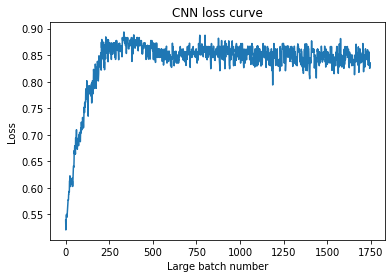

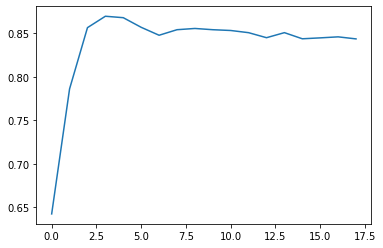

0.893125
0.835


In [0]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
#plt.savefig('/content/ROC_losses_graph/loss_curve_12')
plt.show()


a = np.reshape(l, [-1,97])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

print(max(l))
print(l[-1])

**Classify the test images**

In [0]:
logits = classifier([load_images(test_data1), load_images(test_data2)])
logits = np.array(logits[:,0])
prob = tf.sigmoid(logits)
print(prob)

tf.Tensor(
[0.7674035  0.8613828  0.9337866  0.8024613  0.85865873 0.8824559
 0.82644016 0.80303395 0.8704265  0.81222236 0.85843617 0.7978177
 0.86685413 0.8008843  0.84079254 0.7831389  0.81911784 0.75719386
 0.82548106 0.8466469  0.8318472  0.80867434 0.8322551  0.87737226
 0.85620266 0.86233544 0.82959896 0.9289974  0.80279356 0.82726634
 0.8081564  0.89238894 0.75443393 0.78680176 0.7117371  0.74464726
 0.7629061  0.7747317  0.7631088  0.77321786 0.71869576 0.75780654
 0.7883528  0.74484915 0.78421867 0.7818207  0.79623336 0.68504584
 0.75704277 0.73342955 0.7975528  0.7868259  0.7775714  0.84102714
 0.8242145  0.7741389  0.7756581  0.7678647  0.74834615 0.7474652
 0.7862185  0.79256696 0.7699892  0.7975036  0.7688728  0.76823926
 0.7899056  0.7973848  0.7691939  0.79183596 0.79580283 0.7410829
 0.77719766 0.774716   0.7419961  0.75985163 0.8141875  0.7719191
 0.7584209  0.74509    0.8319152  0.71092564 0.87922466 0.72065455
 0.7776952  0.7525758  0.83967817 0.7667159  0.7698447  

**Calculate final results**

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]

  optimal_accuracy_idx = np.argmax(tpr*32+((1-fpr)*100))
  optimal_accuracy = (tpr[optimal_accuracy_idx]*32+((1-fpr[optimal_accuracy_idx])*100))/132
  optimal_accuracy_threshold = threshold[optimal_accuracy_idx]

  optimal_avgaccuracy_idx = np.argmax(tpr + 1 - fpr)
  optimal_avgaccuracy = (tpr[optimal_avgaccuracy_idx]+1-fpr[optimal_avgaccuracy_idx])/2
  optimal_avgaccuracy_threshold = threshold[optimal_avgaccuracy_idx]

  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.show()
  return roc_auc, optimal_threshold, optimal_accuracy, optimal_accuracy_threshold, optimal_avgaccuracy, optimal_avgaccuracy_threshold

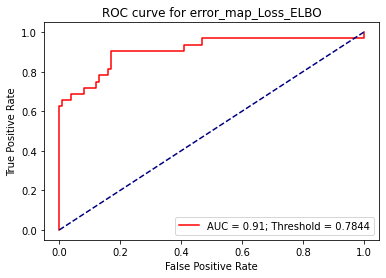

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,84.8,86.8,29,17,83,3,90.8


In [0]:
loss_num = 'ELBO'

prob = np.load('/content/drive/My Drive/SPACE_DATA/ROC_curves/ELBO/test12.npy')
auc_value, threshold_value, _, threshold_max_value, _, threshold_avg_value = threshold_ROC(test_labels, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(test_labels),])
y_predicted[np.where(prob >= threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(test_labels),):
  if test_labels[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if test_labels[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(test_labels)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)